# Visualization and Keras Convolutional Neural Network for Image Classification
## Using Cats and Dogs open source dataset

In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import glob
import os
import matplotlib.pyplot as plt

In [3]:
import zipfile

zip_files_input = ['test1', 'train']

for z in zip_files_input:
    with zipfile.ZipFile("../input/dogs-vs-cats/{}.zip".format(z), 'r') as i:
        i.extractall(".")
        print("{} unzipped".format(z))

test1 unzipped
train unzipped


In [4]:
IMAGE_FOLDER_PATH = "../working/train"
FILE_NAMES = os.listdir("../working/train")
WIDTH = 150
HEIGHT = 150

targets=list()
full_paths=list()
for file_name in FILE_NAMES:
    target=file_name.split(".")[0]
    full_path=os.path.join(IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(target)

df=pd.DataFrame()
df['image_path']=full_paths
df['label']=targets
df.head(10)

,image_path,label
0,../working/train/dog.7301.jpg,dog
1,../working/train/dog.1903.jpg,dog
2,../working/train/cat.609.jpg,cat
3,../working/train/dog.9628.jpg,dog
4,../working/train/dog.10788.jpg,dog
5,../working/train/dog.2584.jpg,dog
6,../working/train/dog.2793.jpg,dog
7,../working/train/dog.4871.jpg,dog
8,../working/train/cat.11199.jpg,cat
9,../working/train/cat.9915.jpg,cat


In [5]:
print("Shape of training data: ", df.shape)
print("Number of cat images: ", len(df[df['label']=='cat']))
print("Number of dog images: ", len(df[df['label']=='dog']))

Shape of training data:  (25000, 2)
Number of cat images:  12500
Number of dog images:  12500


### Training data has a net total of 25,000 images of cats and dogs i.e. 12,500 of Cats and 12,500 of Dogs

## Data Visualization in form of Gallery

In [6]:
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="both"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    
    rng_state = np.random.get_state()
    np.random.shuffle(full_paths)
    np.random.set_state(rng_state)
    np.random.shuffle(targets)
    
    for path, target in zip(full_paths, targets):
        # if target doesn't match the label to show (i.e. dog or cat) we can continue
        # we shall not continue is label to show is 'both'
        if target!=show and show!="both":
            continue
        
        counter=counter+1
        
        # break after displaying 100 images
        if counter%100==0:
            break
        
        
        # load image from the path and fix its size
        #print("Image path: ", path)
        img = load_img(path, target_size = (WIDTH, HEIGHT))
        # convert image jpeg to numpy array -- very important step for processing
        img = img_to_array(img)
        
        ## now we need to stack some images horizontally and some wertically so as to form a 10*10 grid
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title={"both":"Dogs and Cats",
          "cat": "Cats",
          "dog": "Dogs"}
    plt.title("100 samples of {} of the dataset".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))

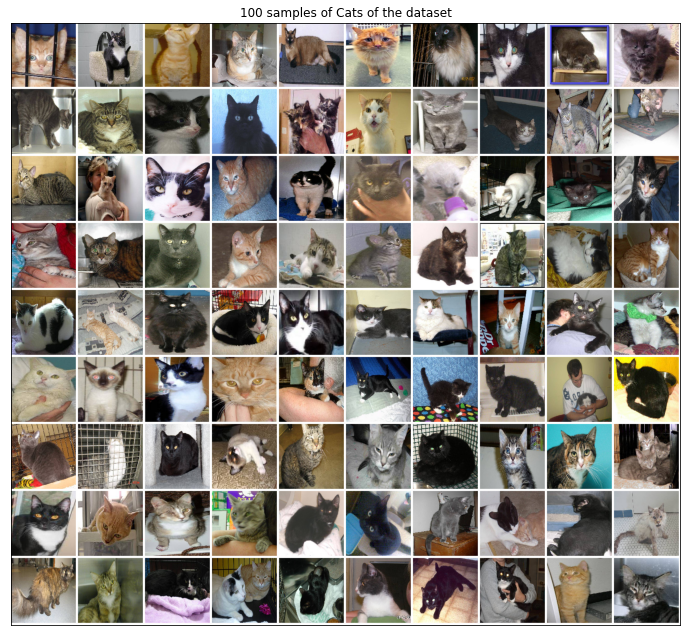

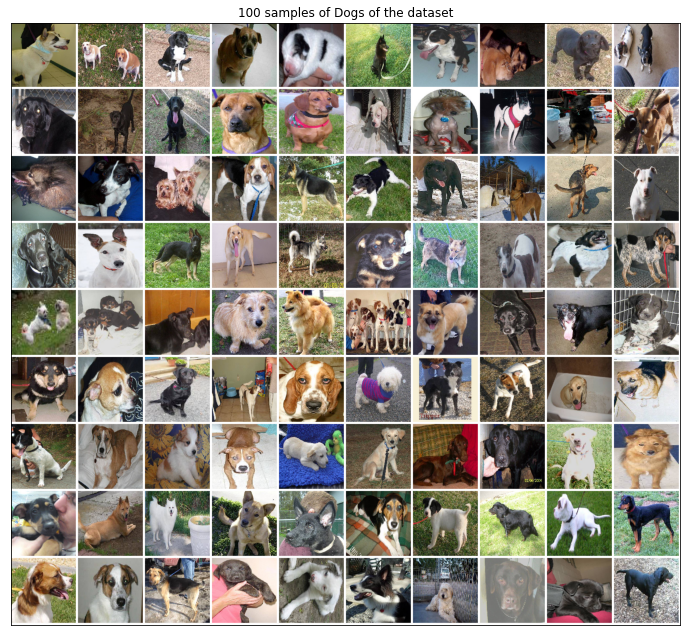

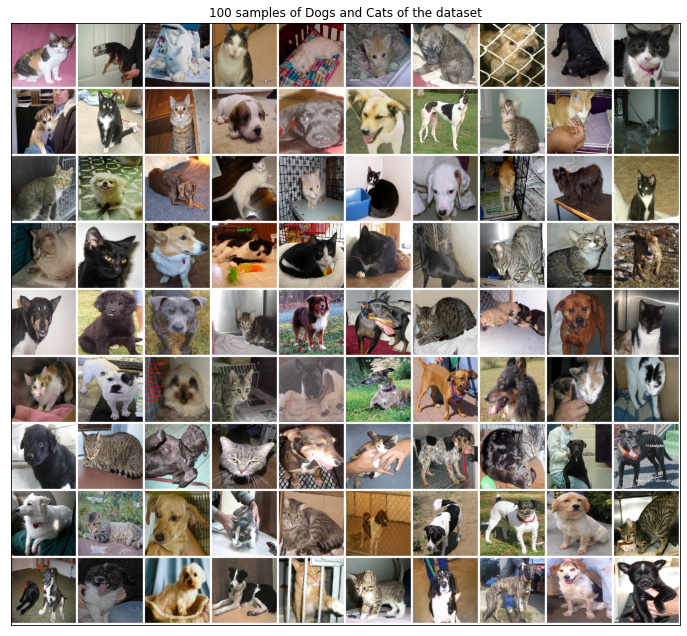

In [7]:
show_gallery('cat')
show_gallery('dog')
show_gallery('both')

## CNN

In [8]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras import applications

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [9]:
######### CNN Model Architecture ##########

model_cnn = models.Sequential()

## Conv2D structure:
# filters/features like edges, corners, etc would be kept as 32
# kernel size -- 2D convolution window
# activation function Relu
# input shape is image shape (width, height, number of channels  -- in this case 3: RGB)

model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
# Batch normalization is used to normalize/standardize input/output of layers in a Sequential model to make them independent
model_cnn.add(layers.BatchNormalization())
# Max Pooling helps to account for distortions/rotation/changes in the image -- this is different from padding
model_cnn.add(layers.MaxPooling2D((2,2)))
# dropout - to prevent overfitting -- randomly dropping nodes while backprop during training 
model_cnn.add(layers.Dropout(0.25))

model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D((2,2)))
model_cnn.add(layers.Dropout(0.25))

model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D((2,2)))
model_cnn.add(layers.Dropout(0.25))

model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model_cnn.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(WIDTH, HEIGHT, 3)))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D((2,2)))
model_cnn.add(layers.Dropout(0.25))

model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(512, activation="relu"))
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Dense(1, activation="sigmoid"))

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 146, 146, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 32)        9

In [10]:
# Compiling the model
model_cnn.compile(loss="binary_crossentropy",
                 optimizer = optimizers.RMSprop(),
                 metrics=["accuracy"])

print("model compiled...")

model compiled...


In [11]:
# Splitting the train data of 25,000 images into train and val

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [12]:
print("Size of training set now: ", train_df.shape)
print("Size of validation set: ", val_df.shape)

Size of training set now:  (20000, 2)
Size of validation set:  (5000, 2)


In [13]:
# Image Data Generator helps to augment images in real-time while the model is training
# It applies below mentioned transformations to each training image as it is passed to the model
# Helps to make model robust and save overhead memory

train_datagen = ImageDataGenerator(rotation_range = 15,
                                          rescale = 1./255,
                                          shear_range=0.1,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          width_shift_range=0.1,
                                          height_shift_range=0.1)

train_datagenerator = train_datagen.flow_from_dataframe(dataframe = train_df,
                                                       x_col="image_path",
                                                       y_col="label",
                                                       target_size=(WIDTH, HEIGHT),
                                                       class_mode = "binary",
                                                       batch_size=150)

Found 20000 validated image filenames belonging to 2 classes.


In [19]:
train_datagen

In [20]:
train_datagenerator

In [14]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_datagenerator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                   x_col="image_path",
                                                   y_col="label",
                                                   target_size=(WIDTH, HEIGHT),
                                                   class_mode="binary",
                                                   batch_size=150)

Found 5000 validated image filenames belonging to 2 classes.


In [15]:
model_cnn_trained = model_cnn.fit(train_datagenerator, 
                                           epochs=50,
                                           validation_data = val_datagenerator,
                                           validation_steps = val_df.shape[0]//150,
                                           steps_per_epoch = train_df.shape[0]//150) # // is floor division to round the result of division to the nearest whole number

Epoch 1/50
133/133 [==============================] - 178s 1s/step - loss: 1.2116 - accuracy: 0.5560 - val_loss: 1.1438 - val_accuracy: 0.4976
Epoch 2/50
133/133 [==============================] - 169s 1s/step - loss: 0.6434 - accuracy: 0.6364 - val_loss: 1.4160 - val_accuracy: 0.4970
Epoch 3/50
133/133 [==============================] - 169s 1s/step - loss: 0.5824 - accuracy: 0.7005 - val_loss: 0.8170 - val_accuracy: 0.5099
Epoch 4/50
133/133 [==============================] - 169s 1s/step - loss: 0.5287 - accuracy: 0.7366 - val_loss: 0.6172 - val_accuracy: 0.6911
Epoch 5/50
133/133 [==============================] - 169s 1s/step - loss: 0.4793 - accuracy: 0.7710 - val_loss: 1.1177 - val_accuracy: 0.6408
Epoch 6/50
133/133 [==============================] - 168s 1s/step - loss: 0.4502 - accuracy: 0.7952 - val_loss: 0.7567 - val_accuracy: 0.6873
Epoch 7/50
133/133 [==============================] - 170s 1s/step - loss: 0.4192 - accuracy: 0.8115 - val_loss: 0.5323 - val_accuracy: 0.7505

## Evaluation

In [17]:
print("Training accuracy: {:.3f}".format(model_cnn_trained.history['accuracy'][-1]))
print("Validation accuracy: {:.3f}".format(model_cnn_trained.history['val_accuracy'][-1]))

Training accuracy: 0.934
Validation accuracy: 0.949


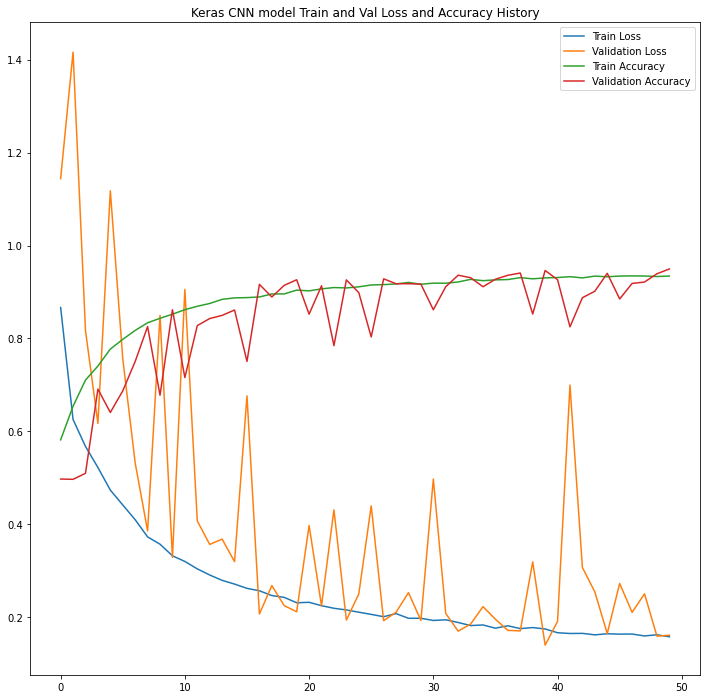

In [18]:
def show_model_history(model, model_name):
    df_history = pd.DataFrame()
    df_history['Train Loss'] = model.history['loss']
    df_history['Validation Loss'] = model.history['val_loss']
    df_history['Train Accuracy'] = model.history['accuracy']
    df_history['Validation Accuracy'] = model.history['val_accuracy']
    
    df_history.plot(figsize=(12,12))
    plt.title("{} model Train and Val Loss and Accuracy History".format(model_name))
    plt.show()
    

show_model_history(model_cnn_trained, "Keras CNN")

## Simple CNN gives good accuracy on both train and val sets (about 94%) but takes a lot of time (2.5 hours) to train

## References: 

<br>
1. Challenge/Dataset: https://www.kaggle.com/c/dogs-vs-cats/data
<br>
2. Notebook referred: https://www.kaggle.com/serkanpeldek/keras-cnn-transfer-learnings-on-cats-dogs-dataset
<br>
3. Theory article: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a